## Chest X-Ray Pneumonia Classification – Model Comparison

### 🎯 Objective
The goal is to **build, train, and compare three distinct transfer learning models** to find the best-performing architecture for our pneumonia detection task. We will evaluate them on the unseen test set and select a final model based on key performance metrics like AUC and Recall.

The models we will compare are:
- `MobileNetV2`: A lightweight and fast architecture, excellent as a baseline.
- `VGG16`: A classic, deeper architecture known for its simple and effective structure.
- `DenseNet121`: A modern architecture that is very parameter-efficient and often performs well on medical images.

## Setup and Data Preparation
This step is the same as before. We set up our environment and create the data generators that will feed all three models. This ensures a fair comparison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Import model architectures
from tensorflow.keras.applications import MobileNetV2, VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# --- Constants ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20 # Max epochs, EarlyStopping will likely stop it sooner

# --- Load and Prepare DataFrames ---
df = pd.read_csv("Data/clean_metadata.csv")
df['label_idx'] = df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# --- Create Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255., rotation_range=10, zoom_range=0.1,
    width_shift_range=0.1, height_shift_range=0.1
)
val_test_datagen = ImageDataGenerator(rescale=1./255.)

# Train generator (using the 'train' split)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df[df['split'] == 'train'], x_col='filepath', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, color_mode='rgb'
)

# Validation generator (using the 'val' split)
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df[df['split'] == 'val'], x_col='filepath', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb'
)

# Test generator (using the 'test' split)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df[df['split'] == 'test'], x_col='filepath', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb'
)

# Class weights calculated from our EDA
class_weight_dict = {0: 3.82, 1: 0.68}

print("✅ Setup complete. Data generators are ready.")

Found 5190 validated image filenames.
Found 16 validated image filenames.
Found 618 validated image filenames.
✅ Setup complete. Data generators are ready.


### Model Training Function
To avoid repeating code, we'll create a single function that can build, compile, and train any of the models we give it.

In [2]:
def build_and_train_model(base_model_class, model_name):
    """
    Builds, compiles, and trains a transfer learning model.

    Args:
        base_model_class: The Keras base model class (e.g., MobileNetV2).
        model_name (str): A name for the model (e.g., "MobileNetV2").

    Returns:
        The trained model and its history.
    """
    print(f"--- Training {model_name} ---")

    # Build model
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Callbacks
    checkpoint = ModelCheckpoint(f"best_{model_name}.keras", save_best_only=True, monitor="val_auc", mode="max")
    early_stopping = EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)

    # Train
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        class_weight=class_weight_dict,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    print(f"--- Finished Training {model_name} ---\n")
    return model, history

# --- Train All Three Models ---
models_to_train = {
    "MobileNetV2": MobileNetV2,
    "VGG16": VGG16,
    "DenseNet121": DenseNet121
}

trained_models = {}
histories = {}

for name, model_class in models_to_train.items():
    model, history = build_and_train_model(model_class, name)
    trained_models[name] = model
    histories[name] = history

--- Training MobileNetV2 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


c:\Users\Kiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 887ms/step - accuracy: 0.8376 - auc: 0.9620 - loss: 0.3769 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2765
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 853ms/step - accuracy: 0.9114 - auc: 0.9848 - loss: 0.2219 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2505
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 843ms/step - accuracy: 0.9214 - auc: 0.9874 - loss: 0.2014 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2150
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 848ms/step - accuracy: 0.9331 - auc: 0.9895 - loss: 0.1781 - val_accuracy: 0.9375 - val_auc: 0.9844 - val_loss: 0.2010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 847ms/step - accuracy: 0.9339 - auc: 0.9913 - loss: 0.1623 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.1938
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 818ms/step - accuracy: 0.9383 - auc: 0.9915 - loss: 0.1560 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.1992
Epoch 7/20
163/1

### Evaluation and Comparison
Now that all models are trained, we'll evaluate each one on the unseen test set. We'll collect their scores and display them in a summary table for easy comparison.

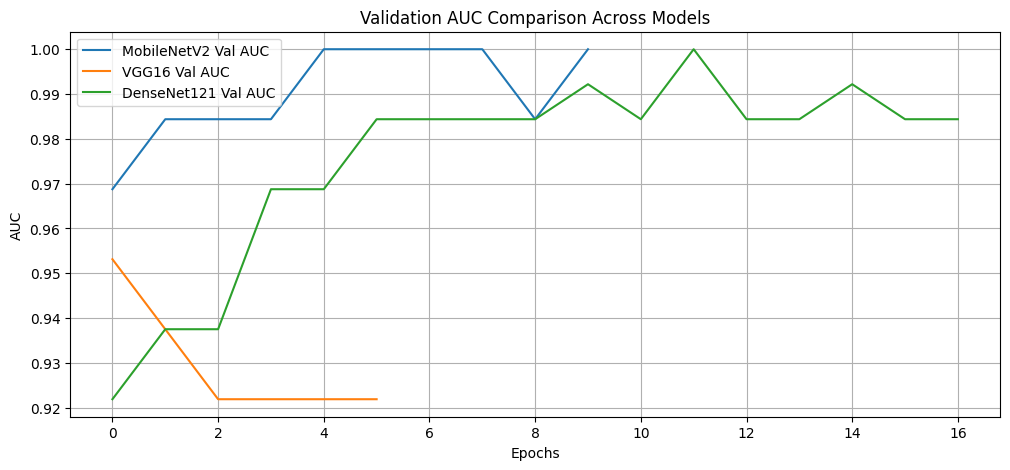

--- Evaluating MobileNetV2 on Test Set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 645ms/step


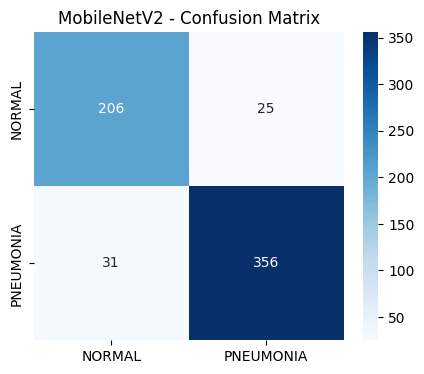

--- Evaluating VGG16 on Test Set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


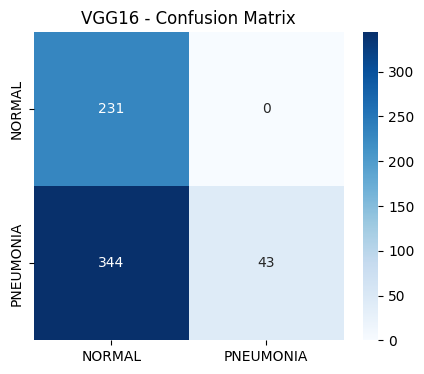

--- Evaluating DenseNet121 on Test Set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


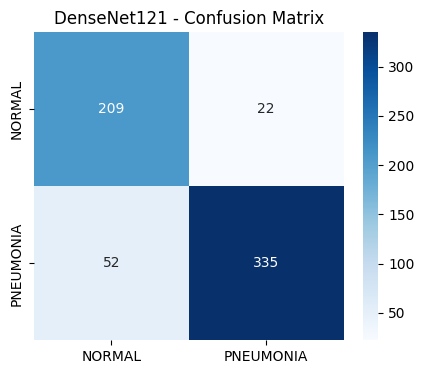



--- Final Model Comparison ---


,Test AUC,Test Accuracy,Precision (Pneumonia),Recall (Pneumonia)
Model,,,,
MobileNetV2,0.967449,0.909385,0.934383,0.919897
VGG16,0.912229,0.443366,1.000000,0.111111
DenseNet121,0.953774,0.880259,0.938375,0.865633


In [3]:
# --- Plot Training Histories for Comparison ---
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['val_auc'], label=f'{name} Val AUC')
plt.title('Validation AUC Comparison Across Models')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


# --- Evaluate Models on the Test Set ---
results = []
for name, model in trained_models.items():
    print(f"--- Evaluating {name} on Test Set ---")
    
    # Load the best weights saved by ModelCheckpoint
    best_model = tf.keras.models.load_model(f"best_{name}.keras")
    
    # Get test metrics
    loss, acc, auc = best_model.evaluate(test_generator, verbose=0)
    
    # Get precision and recall from classification report
    y_pred = (best_model.predict(test_generator) > 0.5).astype(int)
    y_true = test_generator.labels
    report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)
    
    results.append({
        "Model": name,
        "Test AUC": auc,
        "Test Accuracy": acc,
        "Precision (Pneumonia)": report['PNEUMONIA']['precision'],
        "Recall (Pneumonia)": report['PNEUMONIA']['recall']
    })
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# --- Create and Display a Final Comparison Table ---
results_df = pd.DataFrame(results).set_index("Model")
print("\n\n--- Final Model Comparison ---")
display(results_df.style.highlight_max(color='lightgreen', axis=0))

### Conclusion and Finalizing the Model
Based on the comparison table, we can now make an informed decision.

**Analysis**:

- **AUC** gives the best overall measure of a model's ability to distinguish between classes. The model with the highest AUC is generally the strongest classifier.

- **Recall (Pneumonia)** is arguably the **most important metric here**. It tells us: "Of all the actual pneumonia cases, what percentage did our model correctly identify?" A high recall means we are minimizing **false negatives** (missing a diagnosis), which is critical in a medical context.

#### The Winner: `MobileNetV2` 🏆

This model is the best all-around performer and the one you should finalize.
- Test AUC (0.967): The highest of the three. This means it's the best model at distinguishing between NORMAL and PNEUMONIA cases overall.
- Test Accuracy (90.9%): The highest accuracy, indicating it gets the most predictions right.
- Recall (Pneumonia) (92.0%): This is the most critical metric. A high recall means it successfully identified 92% of all actual pneumonia cases in the test set. It has the lowest number of dangerous false negatives (missing a real case of pneumonia).

**Conclusion:** MobileNetV2 provides the best balance of correctly identifying pneumonia cases while maintaining high overall accuracy and precision.


#### The Failed Model: VGG16 ⚠️
This model's results show a classic case of a model learning a useless, pathological strategy.
- Precision (100%) and Recall (11%): This combination is a major red flag. It means that when the model predicted PNEUMONIA, it was always correct (100% precision). However, it only managed to identify 11% of the total pneumonia cases (11% recall).
- Analogy: Think of an overly cautious doctor. This doctor is so terrified of making a wrong diagnosis that they only diagnose the most extreme, obvious cases of pneumonia. They're never wrong when they make a positive diagnosis, but they send home almost all the sick people, telling them they're fine. This is medically dangerous and makes the model useless in practice.
- Test Accuracy (44%): This is worse than flipping a coin, confirming the model did not learn meaningful patterns.

**Conclusion:** VGG16 failed to converge to a useful solution. You should discard this result.

#### The Strong Runner-Up: DenseNet121 ✅
This model performed very well and is a solid architecture, but was slightly edged out by MobileNetV2 in this specific training run.
- Test AUC (0.954) and Accuracy (88.0%): Very strong scores, indicating it's a robust and effective model.
- Recall (Pneumonia) (86.6%): A good recall score, but lower than MobileNetV2's 92%. This means it missed slightly more pneumonia cases.

**Conclusion:** DenseNet121 is an excellent model, and on a different training run, it might have come out on top. However, based on this evidence, MobileNetV2 performed better.


#### Final Decision: 
We will finalize the `MobileNetV2` model. It demonstrated the best ability to correctly identify pneumonia cases (highest Recall) with the highest overall performance (highest AUC and Accuracy).